In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dtaidistance import dtw
from statsmodels.tsa.stattools import grangercausalitytests

In [9]:
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

In [2]:
public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

emotion_groups_ekman = {
    'joy': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust', 'embarrassment'],
    'surprise': ['surprise', 'realization', 'confusion'],
}

def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')


[Smoothed + Normalized DTW Distance Results]
    emotion  dtw_distance
0       joy     12.043366
1   sadness     10.045961
2     anger      9.317764
3      fear     10.980433
4   disgust     10.681793
5  surprise     12.106128


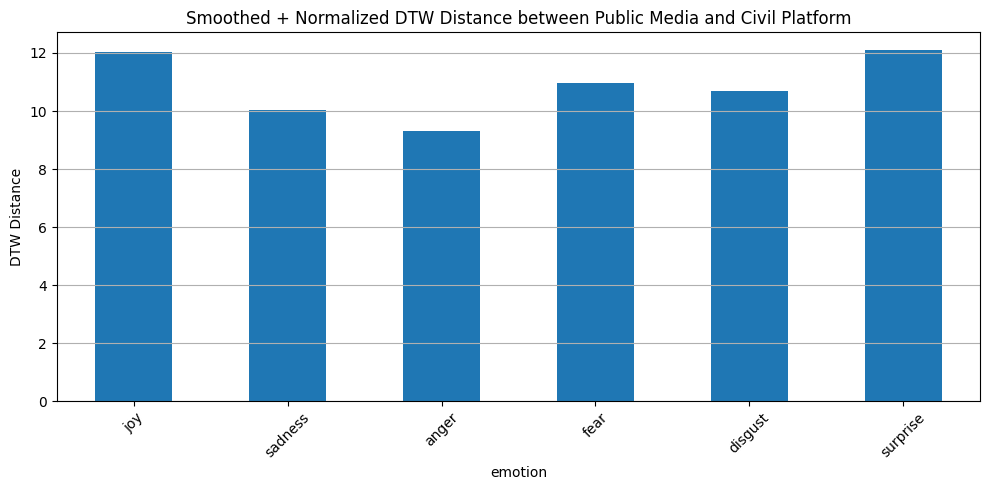

In [3]:
# 감정군 정의
emotion_groups = ['joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

# 1. Smoothing 함수 (centered moving average)
def smooth_df(df, emotions, window=4):
    df_smoothed = df.copy()
    for emotion in emotions:
        df_smoothed[emotion] = df[emotion].rolling(window=window, center=True).mean()
    return df_smoothed.dropna()

# 2. Z-score 정규화 함수
def zscore_normalize(df, columns):
    df_norm = df.copy()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df_norm[col] = (df[col] - mean) / std if std != 0 else 0
    return df_norm

# 3. DTW 계산 함수
def compute_dtw_normalized(public_df, civil_df, emotions):
    results = []
    for emotion in emotions:
        merged = pd.merge(
            public_df[['week', emotion]],
            civil_df[['week', emotion]],
            on='week',
            suffixes=('_public', '_civil')
        )
        if len(merged) < 5:
            continue
        series1 = merged[f'{emotion}_public'].to_numpy()
        series2 = merged[f'{emotion}_civil'].to_numpy()
        distance = dtw.distance(series1, series2)
        results.append({'emotion': emotion, 'dtw_distance': distance})
    return pd.DataFrame(results)

# 4. Public + Civil smoothing
weekly_public_smooth = smooth_df(weekly_public, emotion_groups)
weekly_civil_smooth = smooth_df(weekly_civil, emotion_groups)

# 5. 정규화
weekly_public_smooth_norm = zscore_normalize(weekly_public_smooth, emotion_groups)
weekly_civil_smooth_norm = zscore_normalize(weekly_civil_smooth, emotion_groups)

# 6. DTW 실행
dtw_smooth_results = compute_dtw_normalized(
    weekly_public_smooth_norm,
    weekly_civil_smooth_norm,
    emotion_groups
)

# 7. 출력 및 시각화
print("\n[Smoothed + Normalized DTW Distance Results]")
print(dtw_smooth_results)

dtw_smooth_results.set_index('emotion').plot(kind='bar', legend=False, figsize=(10, 5))
plt.title('Smoothed + Normalized DTW Distance between Public Media and Civil Platform')
plt.ylabel('DTW Distance')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()